In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde, linregress
import pickle as pkl
from utils import u_plot as uplot, u_darrays as uda, u_met
import pandas as pd

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (30., 30.)
#%matplotlib inline

In [2]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [319]:
era_march = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_march.p', 'rb'))
era_oct = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_oct.p', 'rb'))
era_all = pkl.load(open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_allmonth_2000-2014_18UTC.p', 'rb'))
#era_all = pkl.load(open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA5_allmonth_2000-2014.p', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: '/home/ck/DIR/cornkle//data/CLOVER/saves/StormLoc_-50_5000km_WA_ERA5_allmonth_2000-2014_18UTC.p'

In [291]:
np.median(era_all['q925_s'])

0.015520212706178427

In [292]:
np.median(era_all['q925'])

0.015418616589158773

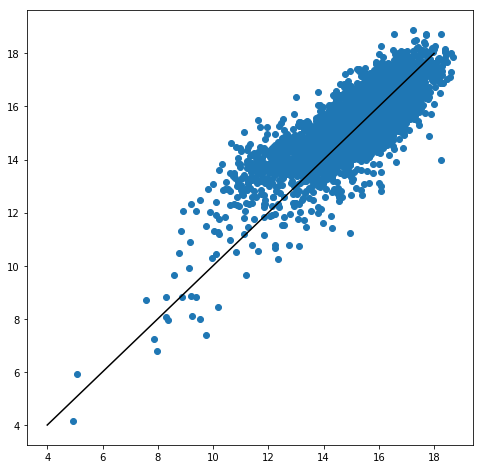

In [293]:
plt.figure(figsize=(8,8))
plt.scatter(np.array(era_all['q925_s'])*1000,np.array(era_all['q925'])*1000)
plt.plot(np.arange(4,19), np.arange(4,19), 'k')

(array([1.500e+01, 5.400e+01, 2.720e+02, 1.084e+03, 4.165e+03, 3.832e+03,
        5.350e+02, 4.000e+01, 7.000e+00, 2.000e+00]),
 array([-3.96803021, -3.14501496, -2.32199971, -1.49898445, -0.6759692 ,
         0.14704606,  0.97006131,  1.79307656,  2.61609182,  3.43910707,
         4.26212233]),
 <a list of 10 Patch objects>)

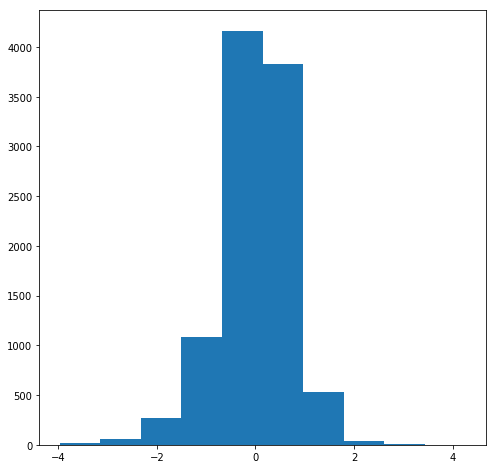

In [294]:
plt.figure(figsize=(8,8))
plt.hist(np.array(era_all['q925_s'])*1000-np.array(era_all['q925'])*1000)

In [295]:
diff = np.array(era_all['q925_s'])*1000-np.array(era_all['q925'])*1000
print(np.sum(diff>0))
print(np.sum(diff<0))

5497
4509


In [296]:
level = era_march.pop('level')
level = era_oct.pop('level')
level = era_all.pop('level')

In [297]:
level[0:18]

[200,
 250,
 300,
 350,
 400,
 450,
 500,
 550,
 600,
 650,
 700,
 750,
 825,
 850,
 875,
 900,
 925,
 950]

In [298]:
for k in era_march.keys():
    era_march[k] = era_march[k][0:1841]

In [299]:
for k in era_oct.keys():
    era_oct[k] = era_oct[k][0:2096]

In [300]:
np.array(era_oct['CAPE']).mean()

1063.4757279858334

In [301]:
np.array(era_march['CAPE']).mean()

1237.0779014713798

In [302]:
era_new = era_all.copy()
octt = era_all.copy()
marchh = era_all.copy()

In [303]:
for k in era_all.keys():
    print(k)
#     if k == 'dates':
#         continue
    varlist = []
    varo = []
    varm = []
    for ids, ise in enumerate(era_all[k]):
        if (era_all['dates'][ids].month <=6) | (era_all['dates'][ids].month >=9):
            varlist.append(ise)
        if era_all['dates'][ids].month == 3:
            varm.append(ise)
        if era_all['dates'][ids].month == 10:
            varo.append(ise)
    era_new[k] = np.array(varlist)          
    octt[k] = np.array(varo)
    marchh[k] = np.array(varm)

q925_s
area70
r_col_s
tcwv
q925
u_col
q700
t10
CAPE_s
q_col_s
dates
u_col_s
tmean
tcwv_s
u925
u925_s
u650_s
v_col_s
r_col
CAPE
u650
v_col
q700_s
lon
lat
tmin
area
q_col


In [304]:
qmsort = np.argsort(marchh['q925'])
qm = marchh['q925'][qmsort]

In [305]:
qesort = np.argsort(np.array(era_march['q925']))
qe = np.array(era_march['q925'])[qesort]

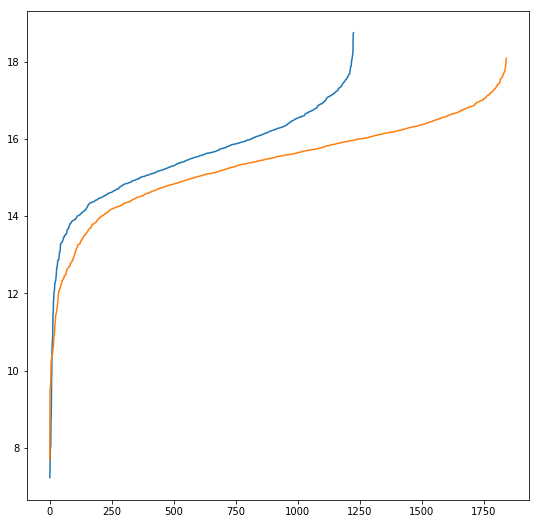

In [306]:
f=plt.figure(figsize=(9,9))
ax = f.add_subplot(111)
plt.plot(qm*1000)
plt.plot(qe*1000)

In [307]:
def get_col(var):
    vdic = {}
    vdic['low'] = []
    vdic['high'] = []
    vdic['mean'] = []
    for v in var:
        
        vdic['low'].append(v[16])
        vdic['high'].append(v[9])
        vdic['mean'].append(np.array(v).mean())        
    return vdic

In [308]:
def sort_vars(dic):
    q925 = np.array(dic['q925'])
    q925s = np.array(dic['q925_s'])
    
    udic = get_col(dic['u_col'])
    vdic = get_col(dic['v_col'])
    
    ushear = (np.array(udic['high'])-np.array(udic['low']))
    vshear = (np.array(vdic['high'])-np.array(vdic['low']))
    shearss = u_met.u_v_to_ws_wd(ushear, vshear)
    
    shears = shearss[0]
    #shears = np.array(dic['u650']) - np.array(dic['u925']) #shearss[0]
    q925 = q925 #(q925s-
    sort = np.argsort(q925)
    q = q925[sort]*1000
    shear = shears[sort]
    tmin = np.array(dic['tmean'])[sort]
    linsp = np.linspace(0,len(q)-1,10)
    
    inds = np.round(linsp).astype(int)
    #ipdb.set_trace()
    f=plt.figure(figsize=(13,9))
    ax = f.add_subplot(311)
    plt.plot(q)
    #plt.ylim(8,18)
    ax = f.add_subplot(312)
    plt.plot(shear,'r')
    ax = f.add_subplot(313)
    plt.plot(tmin,'k')
    
    plt.show()
    
    qmean = []
    corr = []
    qcorr = []
    
    for start,end in enumerate(inds[2::]):  #
        #ipdb.set_trace()
        qmean.append(np.median(q[start:end]))
        corr.append(stats.pearsonr(shear[start:end],tmin[start:end])[0])    
        qcorr.append(stats.pearsonr(shear[start:end],q[start:end])[0])  

#         ttslope, intercept, r, p, std_err = linregress(shear[start:end],tmin[start:end])
#         ccslope, intercept, r, p, std_err = linregress(shear[start:end],q[start:end])
#         corr.append(ttslope)    
#         qcorr.append(ccslope)  
    return qmean, corr, qcorr

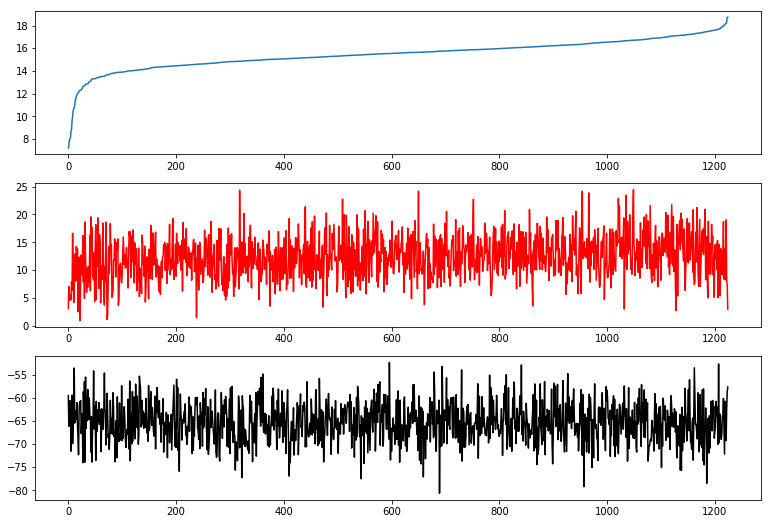

In [309]:
qmean_march, corr_march, qcorr_march = sort_vars(marchh)

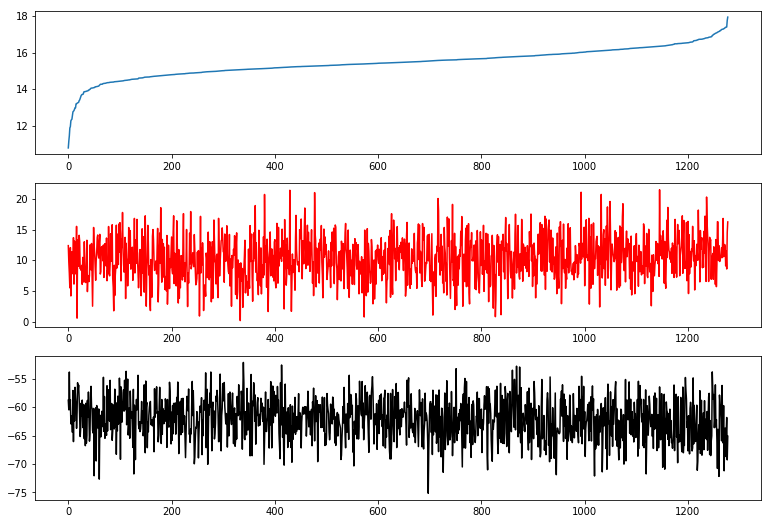

In [310]:
qmean_oct, corr_oct, qcorr_oct = sort_vars(octt)

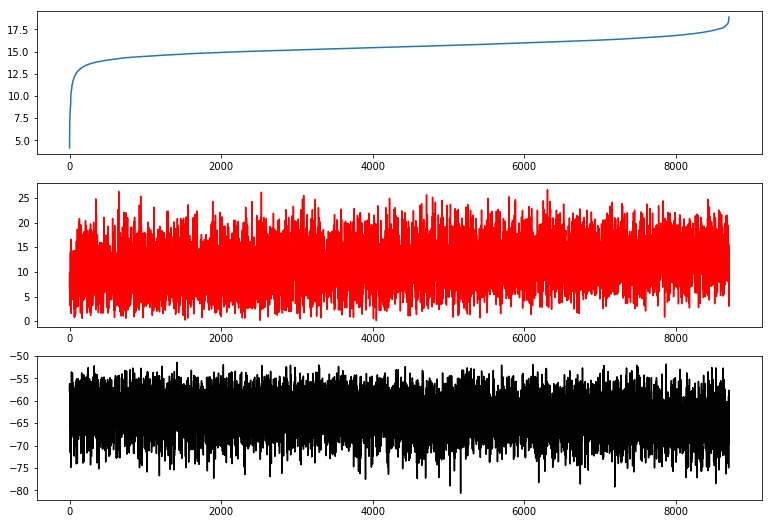

In [311]:
qmean_all, corr_all, qcorr_all = sort_vars(era_new)

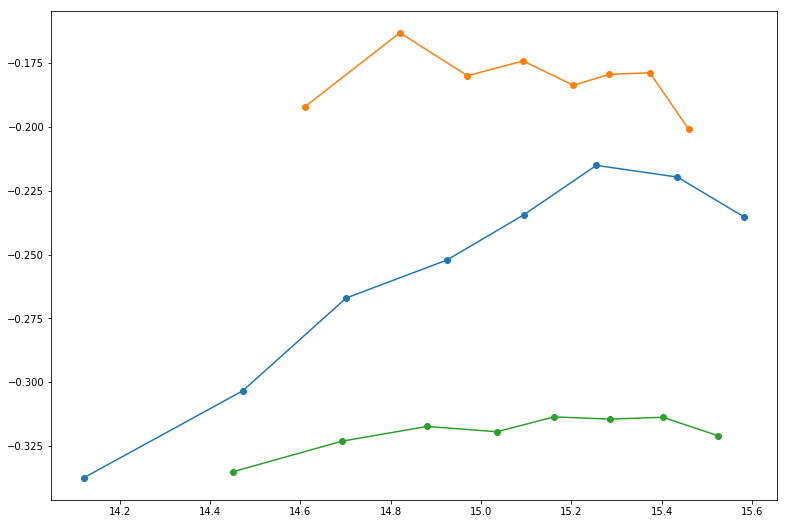

In [312]:
plt.figure(figsize=(13,9))
plt.plot(np.array(qmean_march),corr_march, '-o')
plt.plot(np.array(qmean_oct),corr_oct, '-o')
plt.plot(np.array(qmean_all),corr_all, '-o')

In [313]:
def sort_vars(dic):
    q925 = np.array(dic['q925'])
    q925s = np.array(dic['q925_s'])
    
    udic = get_col(dic['u_col'])
    vdic = get_col(dic['v_col'])
    qdic = get_col(dic['q_col'])
    qdics = get_col(dic['q_col_s'])
    
    ushear = (np.array(udic['high'])-np.array(udic['low']))
    vshear = (np.array(vdic['high'])-np.array(vdic['low']))
    shearss = u_met.u_v_to_ws_wd(ushear, vshear)
    shears = np.array(dic['u650']) - np.array(dic['u925']) #shearss[0]
    
    
    q925 = (q925s-q925) #np.array(qdics['high'])-np.array(qdic['high'])#
    sort = np.argsort(q925)
    q = q925[sort]*1000
    shear = shears[sort]
    tmin = np.array(dic['tmin'])[sort]
    linsp = np.linspace(0,len(q)-1,15)
    
    inds = np.round(linsp).astype(int)
    #ipdb.set_trace()
    f=plt.figure(figsize=(13,9))
    ax = f.add_subplot(311)
    plt.plot(q)
    #plt.ylim(8,18)
    ax = f.add_subplot(312)
    plt.plot(shear,'r')
    ax = f.add_subplot(313)
    plt.plot(tmin,'k')
    
    plt.show()
    
    qmean = []
    corr = []
    qcorr = []
    
    for start,end in enumerate(inds[2::]):  #
        #ipdb.set_trace()
        qmean.append(np.median(q[start:end]))
#         corr.append(stats.pearsonr(shear[start:end],tmin[start:end])[0])    
#         qcorr.append(stats.pearsonr(shear[start:end],q[start:end])[0])  

        ttslope, intercept, rc, p, std_err = linregress(shear[start:end],tmin[start:end])    
        ccslope, intercept, rt, p, std_err = linregress(q[start:end], shear[start:end])
        corr.append(ttslope) 
        qcorr.append(ccslope) 
    return qmean, corr, qcorr

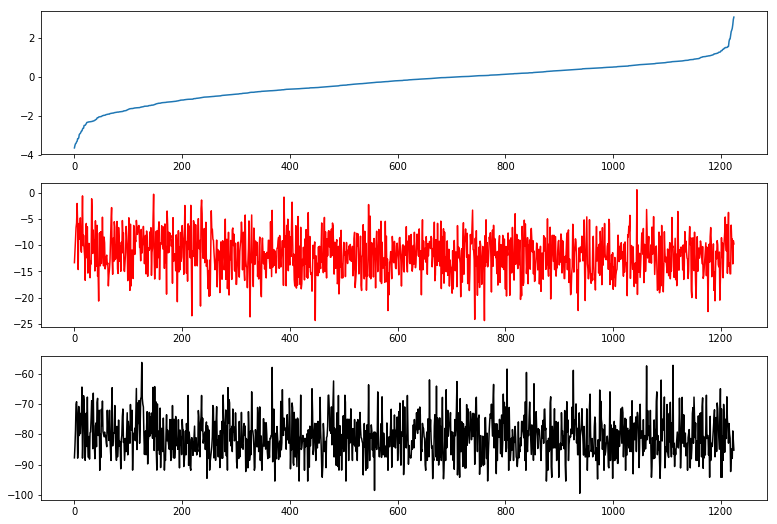

In [314]:
qmean_march, corr_march, qcorr_march = sort_vars(marchh)

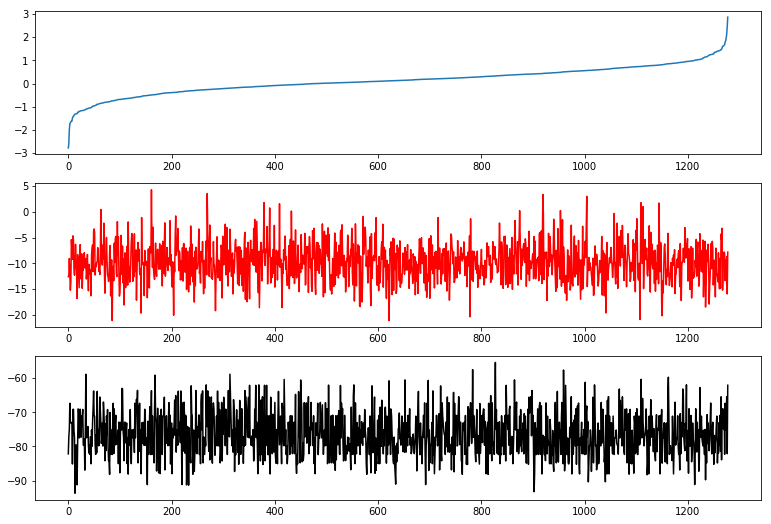

In [315]:
qmean_oct, corr_oct, qcorr_oct = sort_vars(octt)

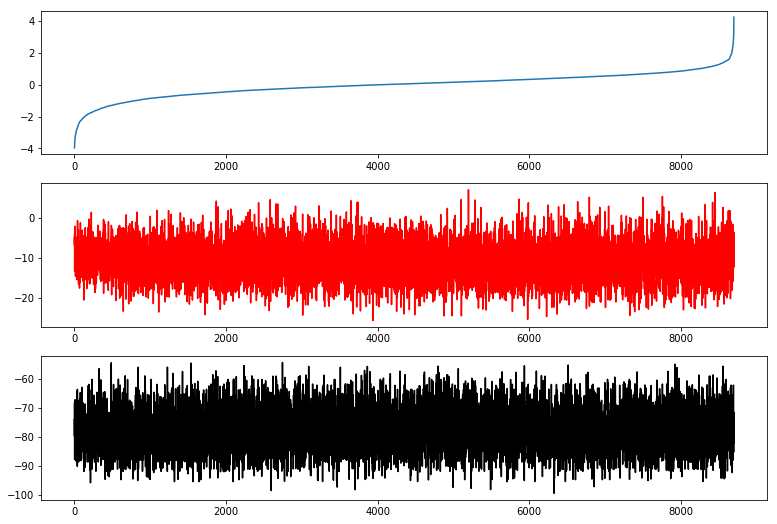

In [316]:
qmean_all, corr_all, qcorr_all = sort_vars(era_new)

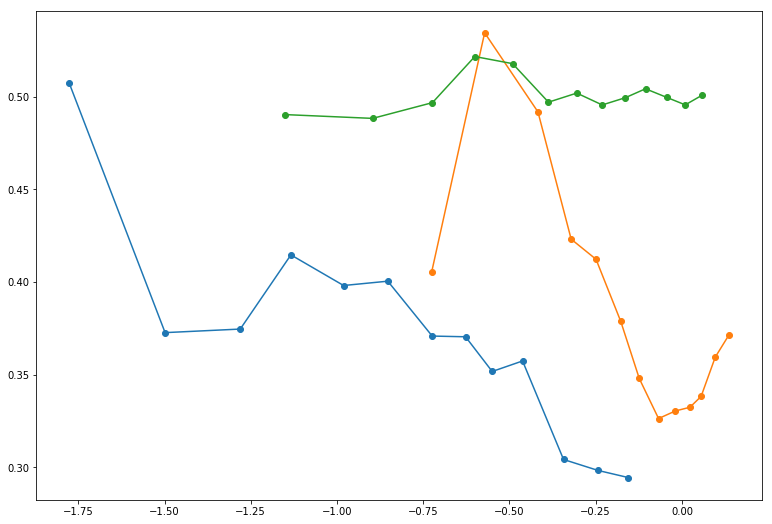

In [318]:
plt.figure(figsize=(13,9))
plt.plot(np.array(qmean_march),corr_march, '-o')
plt.plot(np.array(qmean_oct),corr_oct, '-o')
plt.plot(np.array(qmean_all),corr_all, '-o')